In [1]:
import sys
sys.path.append('../')

In [186]:
pip install pprintpp 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
from ortools.sat.python import cp_model
from pprintpp import pprint as pp
from vrp_study.data_model import Tariff, Cargo, Node
from vrp_study.data_model import TariffCost
from vrp_study.routing_manager import PDRoutingManager
from vrp_study.ortools_routing_model.routing_model import find_optimal_paths

load c:\Users\Nikita\anaconda3\envs\crossdocking\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\Nikita\anaconda3\envs\crossdocking\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\Nikita\anaconda3\envs\crossdocking\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\Nikita\anaconda3\envs\crossdocking\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\Nikita\anaconda3\envs\crossdocking\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\Nikita\anaconda3\envs\crossdocking\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\Nikita\anaconda3\envs\crossdocking\Lib\site-packages\ortools\.libs\ortools.dll...


In [82]:
benchmark_type = 'pdptw1000'
name = 'LRC1_10_10.txt'

In [83]:
from typing import Optional

tariff = None
cargos: list[Cargo] = []
depo: Optional[Node] = None

In [84]:
id2info = {}
p2coordinates = {}
with open(f'../data/Li & Lim benchmark/{benchmark_type}/{name}', 'r') as file:
    for i, line in enumerate(file):

        print(line)
        line = line.split('\t')
        if i == 0:
            tariff = Tariff(
                id='car',
                capacity=int(line[1]),
                max_count=int(line[0]),
                cost_per_distance=[TariffCost(
                    min_dst_km=0,
                    max_dst_km=10000,
                    cost_per_km=1,
                    fixed_cost=0
                )]
            )
        else:
            c_id = int(line[0])
            x = int(line[1])
            y = int(line[2])

            mass = int(line[3])

            et = int(line[4])
            lt = int(line[5])
            st = int(line[6])

            pick_up = int(line[7])
            delivery = int(line[8])
            if pick_up == delivery:
                # print(12)
                depo = Node(
                    id=0,
                    cargo_id=c_id,
                    capacity=0,
                    service_time=0,
                    start_time=0,
                    end_time=lt,
                    coordinates=(x, y)
                )
                continue
            if pick_up == 0:
                if c_id not in id2info:
                    id2info[c_id] = {}
                id2info[c_id][0] = (x, y, mass, et, lt, st, c_id, delivery)
            else:
                delivery = c_id
                c_id = pick_up
                if c_id not in id2info:
                    id2info[c_id] = {}
                id2info[c_id][1] = (x, y, mass, et, lt, st, pick_up, delivery)


250	200	1

0	250	250	0	0	1821	0	0	0

1	440	436	18	832	982	10	0	802

2	214	394	10	171	321	10	0	734

3	476	483	-20	324	474	10	200	0

4	352	487	-22	842	992	10	277	0

5	230	197	40	62	212	10	0	248

6	175	239	-10	75	225	10	374	0

7	133	202	-22	401	551	10	199	0

8	328	458	-10	708	858	10	82	0

9	25	499	-30	385	535	10	318	0

10	226	423	-20	174	324	10	440	0

11	313	282	20	103	253	10	0	983

12	60	454	10	287	437	10	0	157

13	239	486	-20	1422	1572	10	465	0

14	102	264	-10	148	298	10	955	0

15	408	452	-10	256	406	10	297	0

16	451	62	5	275	425	10	0	365

17	203	390	-20	147	297	10	311	0

18	92	233	10	164	314	10	0	614

19	7	300	30	285	435	10	0	535

20	409	90	20	225	375	10	0	445

21	307	108	10	177	327	10	0	325

22	347	54	10	235	385	10	0	553

23	406	87	10	253	403	10	0	769

24	371	332	14	470	620	10	0	826

25	116	466	-10	254	404	10	847	0

26	441	265	40	191	341	10	0	215

27	130	140	17	162	312	10	0	137

28	80	117	24	764	914	10	0	759

29	421	387	-17	741	891	10	931	0

30	83	300	-10	440	590	10	618	0

31	136	52	1

In [85]:
depo

Node(id=0, cargo_id=0, capacity=0, start_time=0, end_time=1821, service_time=0, coordinates=(250, 250))

In [86]:

for k, v in id2info.items():
    cargos.append(
        Cargo(
            id=k,
            nodes=[
                Node(
                    cargo_id=k,
                    id=v[i][6] if i == 0 else v[i][7],
                    capacity=v[i][2],
                    service_time=v[i][5],
                    start_time=v[i][3],
                    end_time=v[i][4],
                    coordinates=(v[i][0], v[i][1])
                )
                for i in range(2)
            ]
        )
    )

In [87]:
cargos[0]

Cargo(id=1, nodes=[Node(id=1, cargo_id=1, capacity=18, start_time=832, end_time=982, service_time=10, coordinates=(440, 436)), Node(id=802, cargo_id=1, capacity=-18, start_time=1187, end_time=1337, service_time=10, coordinates=(449, 428))])

In [110]:
depo

Node(id=0, cargo_id=0, capacity=0, start_time=0, end_time=1821, service_time=0, coordinates=(250, 250))

In [89]:
tariff

Tariff(id='car', capacity=200, cost_per_distance=[TariffCost(min_dst_km=0, max_dst_km=10000, cost_per_km=1, fixed_cost=0)], max_count=250)

In [90]:
p2coordinates.update({
    crg.nodes[i].id: crg.nodes[i].coordinates for crg in cargos for i in range(2)
})
p2coordinates[depo.id] = depo.coordinates
distance_matrix = {(u, v): np.sqrt((du[0] - dv[0]) ** 2 + (du[1] - dv[1]) ** 2) for u, du in
                   p2coordinates.items() for
                   v, dv in p2coordinates.items()}
time_matrix = {(u, v): np.sqrt((du[0] - dv[0]) ** 2 + (du[1] - dv[1]) ** 2) for u, du in p2coordinates.items() for
               v, dv in p2coordinates.items()}

In [91]:

routing_manager = PDRoutingManager()

routing_manager.add_cargos(cargos)
routing_manager.add_tariff(tariff)

routing_manager.add_depo(depo)

routing_manager.distance_matrix = distance_matrix
routing_manager.time_matrix = time_matrix

routing_manager.max_time_minutes = 1

routing_manager.build()

In [92]:
dir(routing_manager)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build',
 '_build_distance_matrix',
 '_cargos',
 '_common_end_node',
 '_create_inner_cars',
 '_create_inner_nodes',
 '_depo',
 '_inner_cars',
 '_inner_nodes',
 '_node_to_inner_node',
 '_nodes',
 '_np_dsts',
 '_np_time',
 '_pick_up_and_delivery',
 '_sort_nodes',
 '_start_node',
 '_tariffs',
 '_validate',
 'add_cargo',
 'add_cargos',
 'add_depo',
 'add_node',
 'add_nodes',
 'add_tariff',
 'add_tariffs',
 'build',
 'cargos',
 'cars',
 'create_sub_problem',
 'distance_m

In [93]:
a = routing_manager._build_distance_matrix()

In [94]:
routing_manager._np_dsts

array([[  0.        , 265.88719413, 266.99250926, ..., 239.71858501,
        313.12936624, 313.12936624],
       [265.88719413,   0.        ,  12.04159458, ..., 481.26188297,
        435.09309349, 435.09309349],
       [266.99250926,  12.04159458,   0.        , ..., 485.6871421 ,
        444.32533126, 444.32533126],
       ...,
       [239.71858501, 481.26188297, 485.6871421 , ...,   0.        ,
        231.13848663, 231.13848663],
       [313.12936624, 435.09309349, 444.32533126, ..., 231.13848663,
          0.        ,   0.        ],
       [313.12936624, 435.09309349, 444.32533126, ..., 231.13848663,
          0.        ,   0.        ]], shape=(1045, 1045))

In [95]:
import matplotlib.pyplot as plt

In [96]:
cargos[0].nodes[0].coordinates

(440, 436)

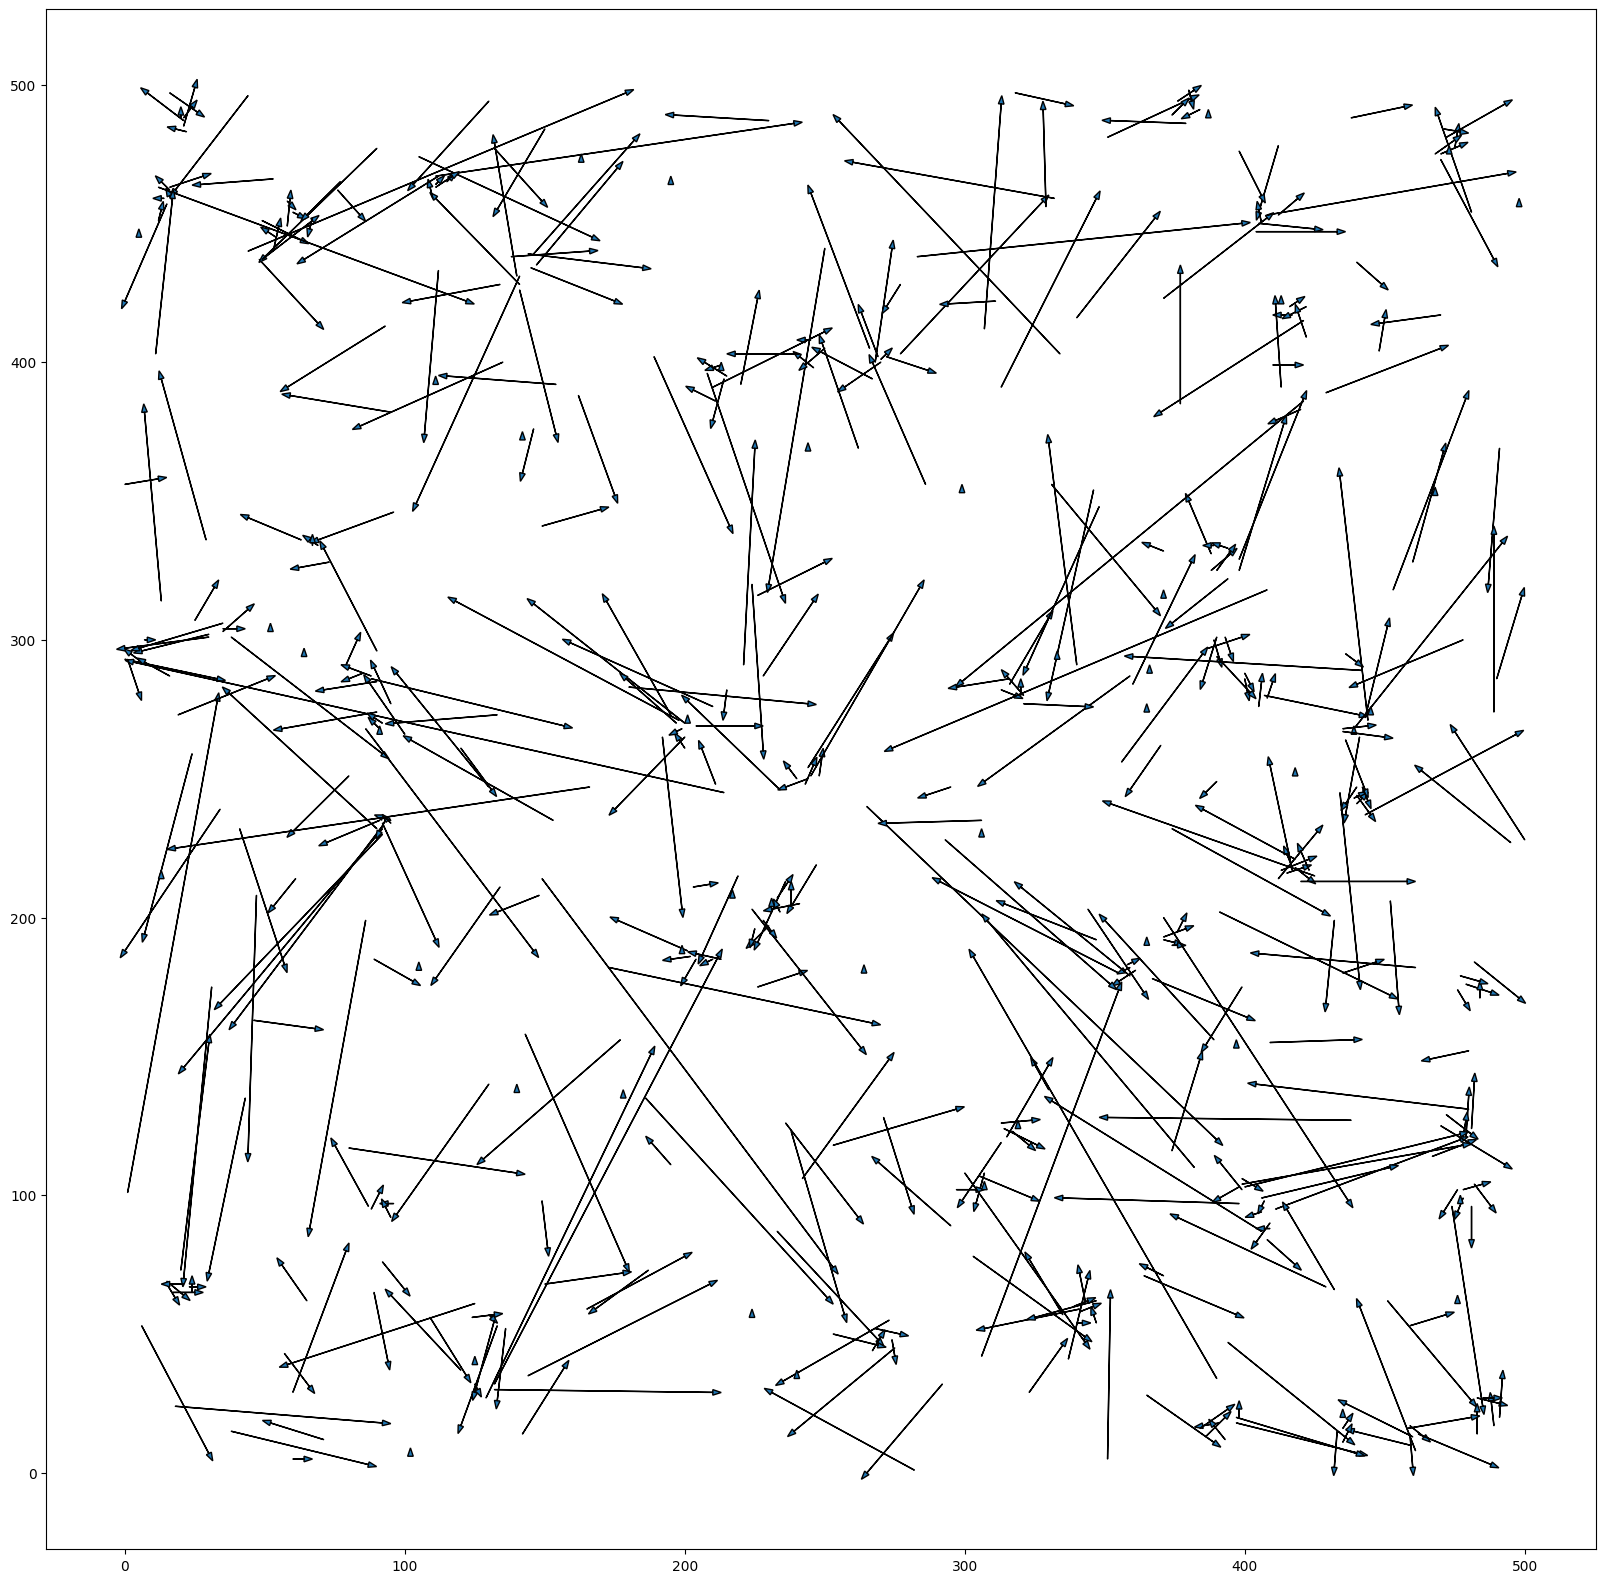

In [100]:
plt.figure(figsize = (20,20))
for cargo in cargos:
    x1,y1 = cargo.nodes[0].coordinates
    x2, y2 = cargo.nodes[1].coordinates
    dx, dy = x2 - x1, y2 - y1
    plt.arrow(x1, y1, dx, dy, head_width=2, width=0.05)

In [292]:
import hdbscan, shapely
from shapely.geometry import LineString

cluster_selection_epsilon = 0
min_cluster_size = 2
alpha = 1
min_samples = min_cluster_size

orders = []
for cargo in cargos:
    x1,y1 = cargo.nodes[0].coordinates
    x2, y2 = cargo.nodes[1].coordinates
    orders.append([x1,y1,x2,y2])
orders = np.array(orders)

# Преобразуем заказы в отрезки
lines = [LineString([(o[0], o[1]), (o[2], o[3])]) for o in orders]

# Кластеризация по расстоянию Хаусдорфа
dist_matrix = np.zeros((len(lines), len(lines)))
for i in range(len(lines)):
    for j in range(len(lines)):
        #dist_matrix[i, j] = lines[i].hausdorff_distance(lines[j])
        mas_len = []
        mas_len.append(routing_manager.distance_matrix[(cargos[i].nodes[0].id,cargos[j].nodes[0].id)])
        mas_len.append(routing_manager.distance_matrix[(cargos[i].nodes[0].id,cargos[j].nodes[1].id)])
        mas_len.append(routing_manager.distance_matrix[(cargos[i].nodes[1].id,cargos[j].nodes[0].id)])
        mas_len.append(routing_manager.distance_matrix[(cargos[i].nodes[1].id,cargos[j].nodes[1].id)])
        dist_matrix[i, j] = max(mas_len)


        #dist_matrix[i, j] = shapely.hausdorff_distance(lines[i], lines[j], densify=0.9)

clusterer = sklearn.cluster.HDBSCAN(metric='precomputed',min_cluster_size=min_cluster_size,min_samples = min_samples,
                                     alpha = alpha,cluster_selection_epsilon =cluster_selection_epsilon)
clusters = clusterer.fit_predict(dist_matrix)

len(set(clusters)),sum(clusters == -1)

(70, np.int64(192))

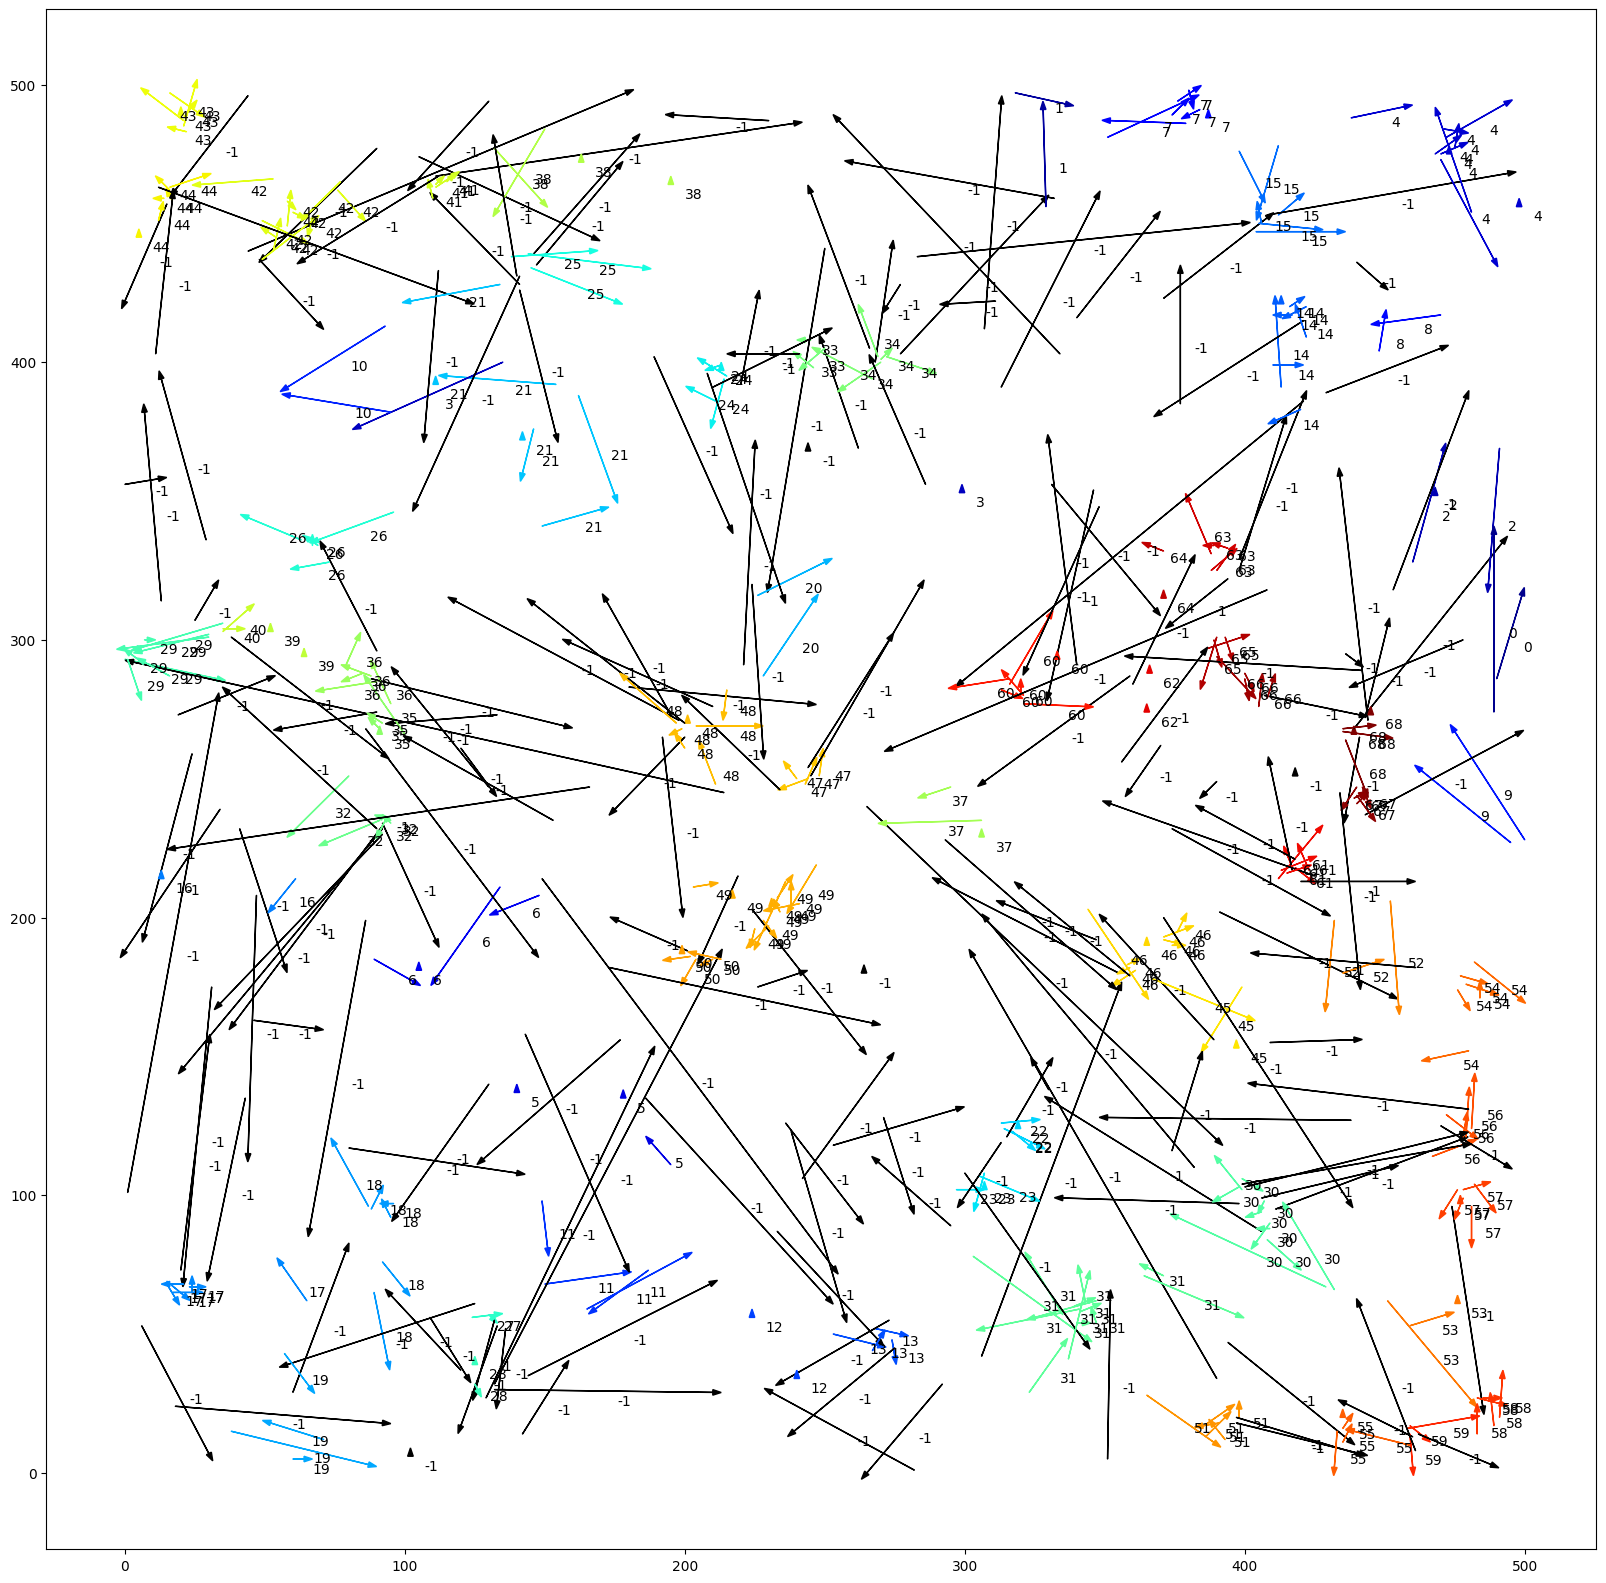

In [294]:
import matplotlib.colors as colors
import matplotlib.cm as cmx


cmap = plt.cm.jet

cNorm  = colors.Normalize(vmin=np.min(clusters), vmax=np.max(clusters))

scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)




plt.figure(figsize = (20,20))
for n,cargo in enumerate (cargos):
    x1,y1 = cargo.nodes[0].coordinates
    x2, y2 = cargo.nodes[1].coordinates
    dx, dy = x2 - x1, y2 - y1
    colorVal = scalarMap.to_rgba(clusters[n])
    if clusters[n] == -1:
        colorVal = (0,0,0,1)
    plt.arrow(x1, y1, dx, dy, head_width=2, width=0.05, color=colorVal)
    plt.annotate(clusters[n],
             xy=(x1 + dx/2, y1 + dy/2),
             xytext=(10, -10),
             textcoords='offset points')
plt.savefig('houosdorf on li&LIM')

In [282]:
colorVal


(np.float64(0.9962049335863377),
 np.float64(0.9302832244008717),
 np.float64(0.0),
 np.float64(1.0))

In [111]:
1

1

In [18]:
sol = find_optimal_paths(routing_manager)

2025-07-01 10:43:05,571 - routing_model [INFO] - problem size: 107
2025-07-01 10:43:05,573 - routing_model [INFO] - Начало создания модели
2025-07-01 10:43:05,577 - routing_model [INFO] - Добавление размерности для расстояния
2025-07-01 10:43:05,579 - routing_model [INFO] - Добавление размерности для расстояния
2025-07-01 10:43:05,580 - routing_model [INFO] - Добавление ограничения для порядка доставки
2025-07-01 10:43:05,581 - routing_model [INFO] - Добавление стоимостей машин
2025-07-01 10:43:05,582 - routing_model [INFO] - add time
2025-07-01 10:43:05,583 - routing_model [INFO] - Добавление ограничений для массы
2025-07-01 10:43:05,600 - routing_model [INFO] - Начало решения
2025-07-01 10:43:05,728 - routing_model [INFO] - find new solution: 90434, best solution: 90434
2025-07-01 10:43:05,734 - routing_model [INFO] - find new solution: 89756, best solution: 89756
2025-07-01 10:43:05,741 - routing_model [INFO] - find new solution: 87378, best solution: 87378
2025-07-01 10:43:05,744 -

In [ ]:
#  best_score: 107
# 2025-06-02 14:45:05,380 - routing_model [INFO] - best_score: 46228.27

In [ ]:
# est_score: 8
# 2025-06-02 14:25:30,179 - routing_model [INFO] - best_score: 1979.21

In [30]:
cargos[0]

Cargo(id=1, nodes=[Node(id=1, cargo_id=1, capacity=10, start_time=0, end_time=1127, service_time=90, coordinates=(45, 68)), Node(id=75, cargo_id=1, capacity=-10, start_time=0, end_time=1130, service_time=90, coordinates=(45, 65))])

In [31]:
total_l = 0
for s in sol[0]:
    if len(s) > 0:
        # print(s)
        l = sum(routing_manager.get_distance(s[i], s[i + 1]) for i in range(len(s) - 1))
        # print(s, l)
        total_l += l
total_l

828.9368669428338

In [33]:
for crg in cargos:
    in1 = routing_manager._node_to_inner_node[crg.nodes[0]]
    in2 = routing_manager._node_to_inner_node[crg.nodes[1]]

    start = None
    end = None
    in_time = None
    out_time = None

    for i, s in enumerate(sol[0]):
        s_time = sol[1][i]
        if len(s) == 0:
            continue

        for order, i in enumerate(s):
            if i == in1.id:
                start = i
                in_time = s_time[order]
            if i == in2.id:
                end = i
                out_time = s_time[order]

    assert start is not None and end is not None and start < end, (start, end)

    if not (crg.nodes[0].start_time <= in_time[0] and crg.nodes[0].end_time >= in_time[1]):
        print(in_time, crg.nodes[0].start_time, crg.nodes[0].end_time)
    if not (crg.nodes[1].start_time <= out_time[0] and crg.nodes[1].end_time >= out_time[1]):
        print(out_time, crg.nodes[0].start_time, crg.nodes[0].end_time)

In [34]:
sol

([[0, 21, 25, 26, 29, 27, 30, 31, 32, 28, 23, 22, 24, 0],
  [0, 65, 73, 69, 67, 71, 74, 66, 72, 75, 76, 68, 70, 0],
  [0, 9, 5, 11, 3, 6, 12, 10, 7, 8, 4, 1, 2, 0],
  [0, 43, 47, 45, 44, 49, 51, 52, 48, 46, 55, 56, 53, 54, 50, 0],
  [0, 91, 93, 92, 89, 87, 90, 88, 95, 94, 96, 0],
  [0, 35, 36, 33, 34, 37, 39, 41, 42, 40, 38, 0],
  [0, 13, 19, 17, 20, 18, 15, 16, 14, 0],
  [0, 101, 97, 103, 102, 98, 99, 105, 106, 104, 100, 0],
  [0, 61, 57, 59, 58, 60, 63, 62, 64, 0],
  [0, 77, 83, 84, 81, 79, 78, 82, 80, 85, 86, 0],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []],
 [[(0, 0),
   (10, 10),
   (105, 105),
   (197, 197),
   (289, 289),
   (382, 382),
   (477, 477),
   (570, 570),
   (570, 570),
   (662, 662),
   (755, 755),
   (848, 848),
   (940, 940),
   (1040, 1040)],
  [(0, 0),
   (12, 12),
   (103, 103),
   (195, 195),
   (290, 290),
   (383, 383),
   (478, 478),
   (571, 571),
   (663, 663),
   (756, 756),
   (756, 756),
   (851, 851),
   (94